<a href="https://colab.research.google.com/github/leokan92/class/blob/main/Aula_2_Modelos_Cl%C3%A1ssicos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Modelos Clássicos

In [ ]:
!pip install pmdarima

##ARIMA e Métricas


### Gerando dados usando ARIMA

In [ ]:
import numpy as np

def generate_trend_seasonality_data(n, trend='linear', seasonality=True, period=12, amplitude=1):
    # Inicializando os arrays
    data = np.zeros(n)

    # Aplicando tendência
    if trend == 'linear':
        data += np.linspace(0, 10, n)  # Tendência linear crescente
    elif trend == 'quadratic':
        data += np.linspace(0, 10, n)**2  # Tendência quadrática

    # Aplicando sazonalidade
    if seasonality:
        for t in range(n):
            data[t] += amplitude * np.sin(2 * np.pi * t / period)

    # Ajustando para positividade
    min_data = np.min(data)
    if min_data < 0:
        data -= min_data  # Ajustando para garantir positividade

    return data

# Parâmetros
n = 100
trend = 'linear'  # Tipo de tendência: 'linear' ou 'quadratic'
period = 12       # Periodicidade da sazonalidade
amplitude = 5     # Amplitude da sazonalidade

# Gerando os dados
data = generate_trend_seasonality_data(n, trend=trend, seasonality=True, period=period, amplitude=amplitude)

print("Dados Gerados:", data)
print("Menor Valor:", np.min(data))  # Verificação para assegurar que todos os valores são positivos


Dados Gerados: [ 4.09090909  6.69191919  8.62305631  9.39393939  8.82507651  7.0959596
  4.6969697   2.2979798   0.56886288  0.          0.77088308  2.7020202
  5.3030303   7.9040404   9.83517752 10.60606061 10.03719773  8.30808081
  5.90909091  3.51010101  1.78098409  1.21212121  1.98300429  3.91414141
  6.51515152  9.11616162 11.04729874 11.81818182 11.24931894  9.52020202
  7.12121212  4.72222222  2.9931053   2.42424242  3.19512551  5.12626263
  7.72727273 10.32828283 12.25941995 13.03030303 12.46144015 10.73232323
  8.33333333  5.93434343  4.20522652  3.63636364  4.40724672  6.33838384
  8.93939394 11.54040404 13.47154116 14.24242424 13.67356136 11.94444444
  9.54545455  7.14646465  5.41734773  4.84848485  5.61936793  7.55050505
 10.15151515 12.75252525 14.68366237 15.45454545 14.88568257 13.15656566
 10.75757576  8.35858586  6.62946894  6.06060606  6.83148914  8.76262626
 11.36363636 13.96464646 15.89578358 16.66666667 16.09780379 14.36868687
 11.96969697  9.57070707  7.84159015  

In [ ]:
# Split data
train_size = int(n * 0.8)
train, test = data[:train_size], data[train_size:]

###Implementação Própria ARIMA

In [ ]:
import numpy as np
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression

# Diferenciação para alcançar a estacionariedade
def difference(data, d):
    for _ in range(d):
        data = np.diff(data)
    return data

# Log-verossimilhança para ARIMA
def log_likelihood(params, data, p, q):
    ar_params = params[:p]
    ma_params = params[p:p+q]
    sigma2 = params[-1] if params[-1] > 0 else 1e-6  # Ensure sigma2 is positive

    predictions, residuals = generate_full_predictions_and_residuals(data, ar_params, ma_params, p, q)

    # Exclude initial observations where predictions are not available
    residuals = residuals[max(p, q):]

    # Compute log-likelihood
    n = len(residuals)
    loglik = -0.5 * n * np.log(2 * np.pi * sigma2) - np.sum(residuals**2) / (2 * sigma2)
    return -loglik  # We minimize negative log-likelihood


# Estimação dos parâmetros usando MLE
from scipy.optimize import minimize

def estimate_parameters(data, p, q):
    init_ar = np.random.uniform(-0.5, 0.5, p)
    init_ma = np.random.uniform(-0.5, 0.5, q)
    init_sigma2 = np.var(data)
    init_params = np.concatenate([init_ar, init_ma, [init_sigma2]])

    bounds = None  # No bounds

    result = minimize(log_likelihood, init_params, args=(data, p, q), method='L-BFGS-B', bounds=bounds)
    if not result.success:
        print("Optimization didn't converge:", result.message)
    return result.x[:p], result.x[p:p+q], result.x[-1]


def generate_full_predictions_and_residuals(data, ar_coeffs, ma_coeffs, p, q):
    n = len(data)
    residuals = np.zeros(n)
    predictions = np.zeros(n)

    for t in range(n):
        ar_part = 0
        ma_part = 0
        if p > 0:
            for i in range(1, p+1):
                if t - i >= 0:
                    ar_part += ar_coeffs[i-1] * data[t - i]
        if q > 0:
            for j in range(1, q+1):
                if t - j >= 0:
                    ma_part += ma_coeffs[j-1] * residuals[t - j]
        predictions[t] = ar_part + ma_part
        residuals[t] = data[t] - predictions[t]

    return predictions, residuals


def generate_forecast(data, ar_coeffs, ma_coeffs, steps, p, q):
    # Estender os dados para incluir previsões futuras
    extended_data = np.append(data, np.zeros(steps))
    # Usar um array para armazenar resíduos calculados e inicializá-lo com zeros
    residuals = np.zeros(len(data) + steps)

    # Calcular resíduos iniciais se q > 0
    for t in range(p, len(data)):
        residuals[t] = data[t] - np.dot(ar_coeffs, extended_data[t-p:t][::-1])

    # Gerar previsões futuras
    for t in range(len(data), len(data) + steps):
        # AR component
        ar_part = np.dot(ar_coeffs, extended_data[t-p:t][::-1]) if p > 0 else 0
        # MA component
        ma_part = np.dot(ma_coeffs, residuals[t-q:t][::-1]) if q > 0 else 0
        # Combinar AR e MA partes
        extended_data[t] = ar_part + ma_part

    return extended_data[-steps:]

# Configuração do modelo
p, d, q = 2, 1, 2  # ordens AR, diferenciação e MA
diff_train = difference(train, d)

# Estimação dos parâmetros
np.random.seed(0)  # Fixar seed para reprodutibilidade
ar_coeffs, ma_coeffs, sigma2 = estimate_parameters(diff_train, p, q)

print("AR coefficients:", ar_coeffs)
print("MA coefficients:", ma_coeffs)
print("Sigma^2:", sigma2)


AR coefficients: [ 1.73030925 -0.99731003]
MA coefficients: [0.00608101 0.00703896]
Sigma^2: 0.000722117021073166


In [ ]:
# Reestimando parâmetros (para garantir consistência na demonstração)
np.random.seed(0)  # Fixar seed para reprodutibilidade
ar_coeffs, ma_coeffs, sigma2 = estimate_parameters(diff_train, p, q)

# ar_params = [0.5, -0.25]  # Coeficientes AR
# ma_params = [0.5, 0.3]    # Coeficientes MA

# Gerando previsões futuras
# ar_params = [1.7314, -0.9990 ]
# ma_params = [1.9329, 0.9758]
# ar_coeffs = np.array(ar_params)
# ma_coeffs = np.array(ma_params)

forecasted_values = generate_forecast(diff_train, ar_coeffs, ma_coeffs, len(test), p, q)
# forecasted_values = generate_forecast(diff_train, ar_params, ma_params, len(test), p, q)
# Reintegrate forecasted values if the model was differenced
forecasted_reintegrated = np.r_[train[-1], forecasted_values].cumsum()[1:]

print("Forecasted values returns:", forecasted_values)
print("Forecasted values:", forecasted_reintegrated)


Forecasted values returns: [-1.75811018 -0.64934377  0.62981538  1.73737243  2.37807038  2.38209824
  1.75009317  0.65251194 -0.61633802 -1.71721208 -2.35662786 -2.36510215
 -1.74206953 -0.65557893  0.60302913  1.69724231  2.33534708  2.34819587
  1.73403997  0.65854611]
Forecasted values: [ 7.8125969   7.16325313  7.7930685   9.53044093 11.90851131 14.29060955
 16.04070272 16.69321467 16.07687665 14.35966457 12.00303671  9.63793456
  7.89586503  7.2402861   7.84331523  9.54055754 11.87590462 14.22410049
 15.95814046 16.61668657]


### Implementação ARIMA StatsModel

In [ ]:
import numpy as np
import statsmodels.api as sm
# Configuração do modelo ARIMA
p, d, q = 2, 1, 2  # ordens AR, diferenciação e MA

# Ajustando o modelo ARIMA
model = sm.tsa.arima.ARIMA(train, order=(p, d, q))
fitted_model = model.fit()
# model = sm.tsa.ARIMA(data, order=(len(ar_params), d, len(ma_params)))
# fitted_model = model.fit(start_params=np.r_[-np.array(ar_params), np.array(ma_params), np.var(data)])  # Providing initial estimates

# Exibindo os resultados
print("Summary of ARIMA model from statsmodels:")
print(fitted_model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Summary of ARIMA model from statsmodels:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   80
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 264.059
Date:                Sat, 14 Sep 2024   AIC                           -518.119
Time:                        20:51:23   BIC                           -506.271
Sample:                             0   HQIC                          -513.372
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7314      0.002    778.441      0.000       1.727       1.736
ar.L2         -0.9990      0.001   -751.962      0.000      -1.002      -0.996
ma.L1      

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Gerar previsões para os próximos 5 períodos
statsmodels_forecast = fitted_model.forecast(steps=len(test))
print("Valores previsto (statsmodels):", statsmodels_forecast)

Valores previsto (statsmodels): [ 7.83433876  7.23160448  7.9226648   9.72127464 12.14497512 14.54450742
 16.27773505 16.88148464 16.1953197  14.40417134 11.98849898  9.5954124
  7.86532471  7.26057227  7.94186414  9.72557726 12.13324457 14.51989919
 16.24684774 16.85259062]


In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse_custom = np.sqrt(mean_squared_error(test, forecasted_reintegrated))
rmse_statsmodels = np.sqrt(mean_squared_error(test, statsmodels_forecast))

print(f"RMSE (Custom Implementation): {rmse_custom}")
print(f"RMSE (Statsmodels): {rmse_statsmodels}")


RMSE (Custom Implementation): 1.3674236389069967
RMSE (Statsmodels): 1.227239549202451


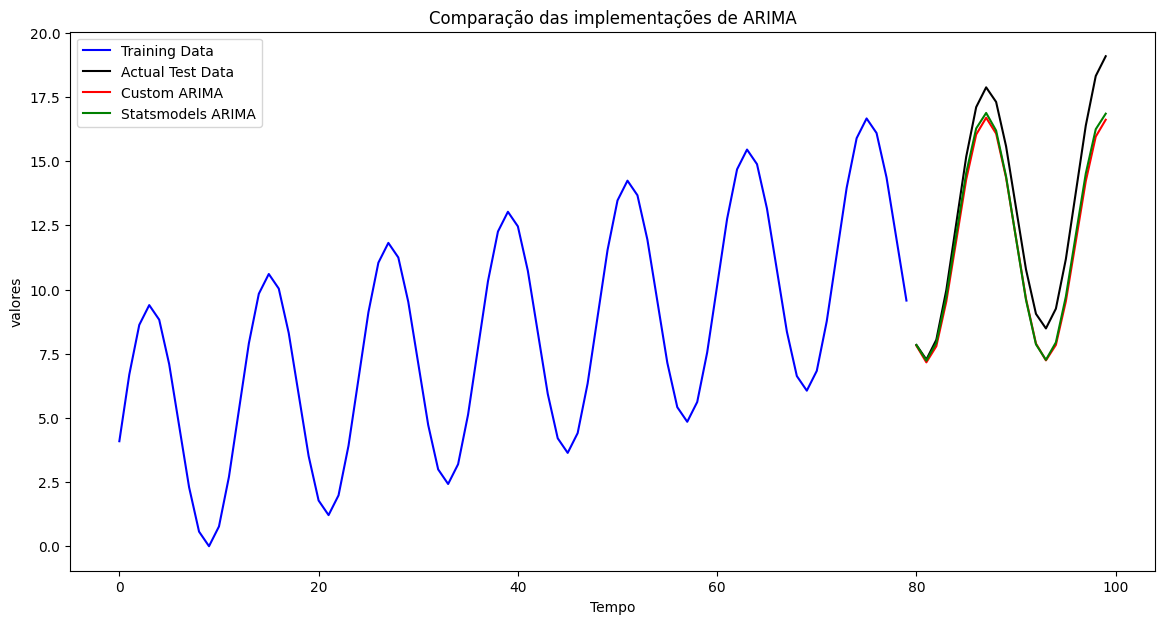

In [ ]:
import matplotlib.pyplot as plt

train_index = np.arange(len(train))
test_index = np.arange(len(train), len(train) + len(test))

plt.figure(figsize=(14, 7))
plt.plot(train_index, train, label='Training Data', color='blue')  # Training data in blue
plt.plot(test_index, test, label='Actual Test Data', color='black')  # Test data in black

plt.plot(test_index, forecasted_reintegrated, label='Custom ARIMA', color='red')  # Custom forecast in red
plt.plot(test_index, statsmodels_forecast, label='Statsmodels ARIMA', color='green')  # Statsmodels forecast in green

plt.xlabel('Tempo')
plt.ylabel('valores')
plt.title('Comparação das implementações de ARIMA')
plt.legend()

plt.show()


In [ ]:
import numpy as np

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def calculate_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def calculate_log_likelihood(y_true, y_pred):
    n = len(y_true)
    resid = y_true - y_pred
    sse = np.sum(resid**2)
    sigma2 = sse / n  # Variance of residuals
    return -0.5 * n * (np.log(2 * np.pi * sigma2) + (sse / (n * sigma2)))

def calculate_aic(y_true, y_pred, k):
    n = len(y_true)
    log_likelihood = calculate_log_likelihood(y_true, y_pred)
    return 2 * k - 2 * log_likelihood

def calculate_bic(y_true, y_pred, k):
    n = len(y_true)
    log_likelihood = calculate_log_likelihood(y_true, y_pred)
    return np.log(n) * k - 2 * log_likelihood


def calculate_r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot

def calculate_adjusted_r_squared(y_true, y_pred, k):
    r_squared = calculate_r_squared(y_true, y_pred)
    n = len(y_true)
    return 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))


In [ ]:
y_true = test
y_pred = forecasted_reintegrated
k = 5  # número de parâmetros no modelo

mape = calculate_mape(y_true, y_pred)
mae = calculate_mae(y_true, y_pred)
rmse = calculate_rmse(y_true, y_pred)
mse = calculate_mse(y_true, y_pred)
aic = calculate_aic(y_true, y_pred, k)
bic = calculate_bic(y_true, y_pred, k)
r_squared = calculate_r_squared(y_true, y_pred)
adjusted_r_squared = calculate_adjusted_r_squared(y_true, y_pred, k)

print("MAPE:", mape)
print("MAE:", mae)
print("RMSE:", rmse)
print("MSE:", mse)
print("AIC:", aic)
print("BIC:", bic)
print("R^2:", r_squared)
print("Adjusted R^2:", adjusted_r_squared)


MAPE: 8.917037181628332
MAE: 1.189568468600011
RMSE: 1.3674236389069967
MSE: 1.8698474082416525
AIC: 79.27467788151232
BIC: 84.25333924928228
R^2: 0.8751513525594836
Adjusted R^2: 0.8305625499021563


##Verossimilhança

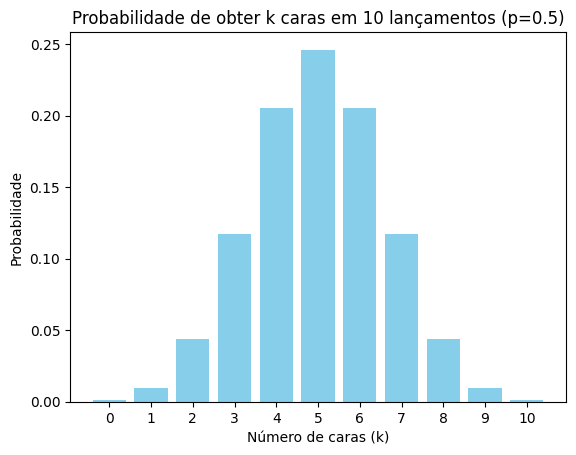

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

# Parâmetros
n = 10  # Número de lançamentos
p = 0.5  # Probabilidade de sucesso (moeda justa)

# Valores possíveis de sucessos (0 a 10 caras)
k = np.arange(0, n+1)

# Probabilidades para cada número de caras
probabilidades = binom.pmf(k, n, p)

# Plotando o gráfico
plt.bar(k, probabilidades, color='skyblue')
plt.title('Probabilidade de obter k caras em 10 lançamentos (p=0.5)')
plt.xlabel('Número de caras (k)')
plt.ylabel('Probabilidade')
plt.xticks(k)
plt.show()


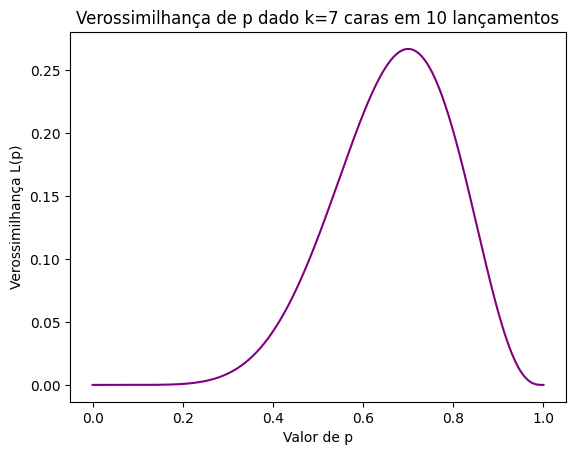

In [ ]:
# Dados observados
k_observado = 7

# Intervalo de valores possíveis para p (de 0 a 1)
p_values = np.linspace(0, 1, 1000)

# Verossimilhança como função de p
verossimilhanca = binom.pmf(k_observado, n, p_values)

# Plotando o gráfico
plt.plot(p_values, verossimilhanca, color='purple')
plt.title('Verossimilhança de p dado k=7 caras em 10 lançamentos')
plt.xlabel('Valor de p')
plt.ylabel('Verossimilhança L(p)')
plt.show()


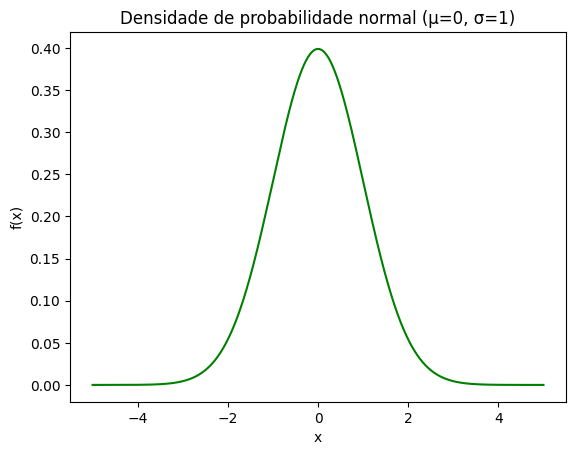

In [ ]:
from scipy.stats import norm

# Parâmetros conhecidos
mu = 0
sigma = 1

# Valores possíveis de x
x = np.linspace(-5, 5, 1000)

# Densidade de probabilidade
probabilidade = norm.pdf(x, mu, sigma)

# Plotando o gráfico
plt.plot(x, probabilidade, color='green')
plt.title('Densidade de probabilidade normal (μ=0, σ=1)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()


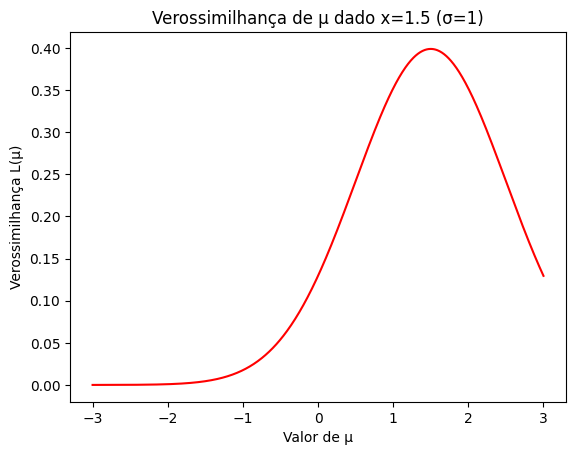

In [ ]:
# Dado observado
x_observado = 1.5

# Valores possíveis para mu (de -3 a 3)
mu_values = np.linspace(-3, 3, 1000)

# Verossimilhança como função de mu
verossimilhanca = norm.pdf(x_observado, mu_values, sigma)

# Plotando o gráfico
plt.plot(mu_values, verossimilhanca, color='red')
plt.title('Verossimilhança de μ dado x=1.5 (σ=1)')
plt.xlabel('Valor de μ')
plt.ylabel('Verossimilhança L(μ)')
plt.show()


##Modelos de suavização exponêncial

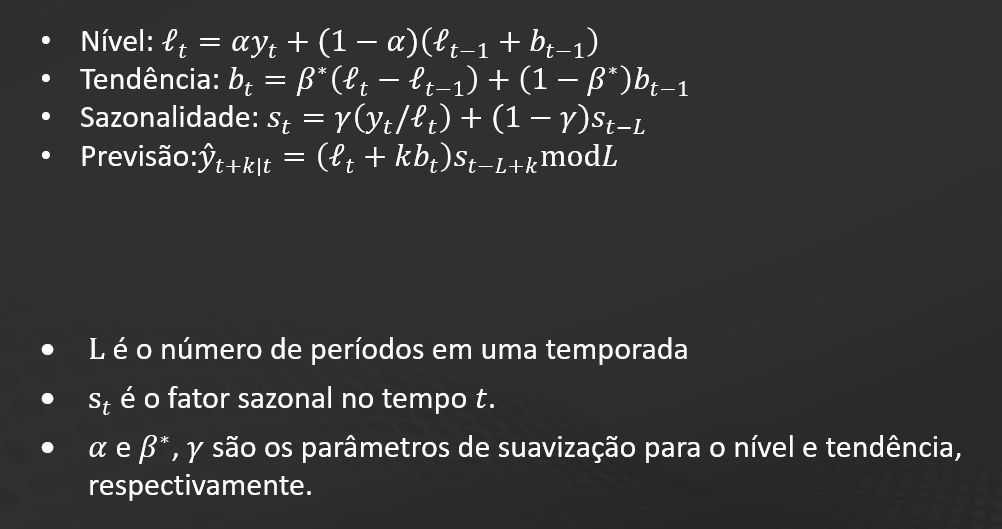

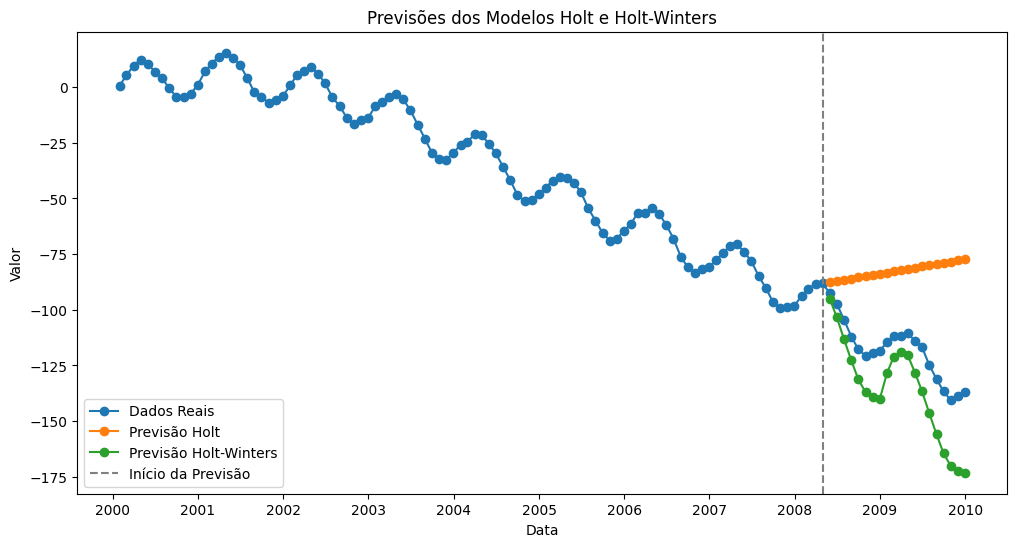

Erro Quadrático Médio (MSE) no período de teste:
Modelo de Holt: 1546.88
Modelo Holt-Winters: 387.43


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def initial_trend(data, seasonal_periods):
    sum = 0.0
    for i in range(seasonal_periods):
        sum += (data[i + seasonal_periods] - data[i]) / seasonal_periods
    return sum / seasonal_periods

def initial_seasonal_components(data, seasonal_periods):
    seasonals = np.zeros(seasonal_periods)
    season_averages = []
    n_seasons = int(len(data) / seasonal_periods)
    # Calcular as médias sazonais
    for j in range(n_seasons):
        season_averages.append(
            sum(data[seasonal_periods * j:seasonal_periods * j + seasonal_periods]) / float(seasonal_periods))
    # Calcular os componentes sazonais iniciais
    for i in range(seasonal_periods):
        sum_over_avg = 0.0
        for j in range(n_seasons):
            sum_over_avg += data[seasonal_periods * j + i] - season_averages[j]
        seasonals[i] = sum_over_avg / n_seasons
    return seasonals

def holt_winters_additive_forecast(data, alpha, beta, gamma, seasonal_periods, forecast_periods):
    n = len(data)
    level = np.zeros(n)
    trend = np.zeros(n)
    forecast = np.zeros(n + forecast_periods)
    seasonal = np.zeros(seasonal_periods)

    # Inicializações
    level[0] = data[0]
    trend[0] = initial_trend(data, seasonal_periods)
    seasonal = initial_seasonal_components(data, seasonal_periods)

    # Suavização
    for t in range(1, n):
        index = t % seasonal_periods
        last_seasonal = seasonal[index]
        level[t] = alpha * (data[t] - last_seasonal) + (1 - alpha) * (level[t - 1] + trend[t - 1])
        trend[t] = beta * (level[t] - level[t - 1]) + (1 - beta) * trend[t - 1]
        seasonal[index] = gamma * (data[t] - level[t]-trend[t]) + (1 - gamma) * last_seasonal
        forecast[t] = level[t - 1] + trend[t - 1] + last_seasonal

    # Previsões futuras
    for m in range(1, forecast_periods + 1):
        index = (n + m - 1) % seasonal_periods
        forecast[n + m - 1] = level[-1] + m * trend[-1] + seasonal[index]

    return forecast

def holt_forecast(data, alpha, beta, forecast_periods):
    n = len(data)
    level = np.zeros(n)
    trend = np.zeros(n)
    forecast = np.zeros(n + forecast_periods)

    # Inicialização
    level[0] = data[0]
    trend[0] = data[1] - data[0]

    # Suavização
    for t in range(1, n):
        level[t] = alpha * data[t] + (1 - alpha) * (level[t - 1] + trend[t - 1])
        trend[t] = beta * (level[t] - level[t - 1]) + (1 - beta) * trend[t - 1]
        forecast[t] = level[t - 1] + trend[t - 1]

    # Previsões futuras
    for m in range(1, forecast_periods + 1):
        forecast[n + m - 1] = level[-1] + m * trend[-1]

    return forecast

# Parameters
n_periods = 120  # Total data points (e.g., 10 years of monthly data)
seasonal_periods = 12  # Seasonal period (months in a year)
alpha = 0.5  # Level smoothing coefficient
beta = 0.3   # Trend smoothing coefficient
gamma = 0.2  # Seasonal smoothing coefficient
np.random.seed(42)  # For reproducibility

# Initialize arrays
level = np.zeros(n_periods)
trend = np.zeros(n_periods)
seasonal = np.zeros(n_periods)
observed = np.zeros(n_periods)

# Initial values
level[0] = 50
trend[0] = 1

# Generate initial seasonal components using a sine function
for i in range(seasonal_periods):
    seasonal[i] = 10 * np.sin(2 * np.pi * i / seasonal_periods)

# Generate data using the Holt-Winters additive model
for t in range(n_periods):
    if t >= seasonal_periods:
        # Observation with noise
        observed[t] = level[t-1] + trend[t-1] + seasonal[t - seasonal_periods] + np.random.normal(0, 1)
        # Update level
        level[t] = alpha * (observed[t] - seasonal[t - seasonal_periods]) + (1 - alpha) * (level[t-1] + trend[t-1])
        # Update trend
        trend[t] = beta * (level[t] - level[t-1]) + (1 - beta) * trend[t-1]
        # Update seasonal component
        seasonal[t] = gamma * (observed[t] - level[t] - trend[t]) + (1 - gamma) * seasonal[t - seasonal_periods]
    else:
        # For initial periods, use existing seasonal components
        observed[t] = level[t-1] + trend[t-1] + seasonal[t] + np.random.normal(0, 1)
        level[t] = alpha * (observed[t] - seasonal[t]) + (1 - alpha) * (level[t-1] + trend[t-1])
        trend[t] = beta * (level[t] - level[t-1]) + (1 - beta) * trend[t-1]
        seasonal[t] = gamma * (observed[t] - level[t] - trend[t]) + (1 - gamma) * seasonal[t]

dates = pd.date_range(start='2000-01-01', periods=n_periods, freq='M')
data = pd.DataFrame({'Date': dates, 'Observed': observed})
data.set_index('Date', inplace=True)

#Parâmetros
alpha = 0.8
beta = 0.2
gamma = 0.4
# alpha = 0.5  # Level smoothing coefficient
# beta = 0.3   # Trend smoothing coefficient
# gamma = 0.2  # Seasonal smoothing coefficient
forecast_periods = 20

data_series = data['Observed'].values
train_size = len(data_series) - forecast_periods
train_data = data_series[:train_size]
test_data = data_series[train_size:]

# Aplicar os modelos
forecast_holt = holt_forecast(train_data, alpha, beta, forecast_periods)
forecast_hw = holt_winters_additive_forecast(train_data, alpha, beta, gamma, seasonal_periods, forecast_periods)

forecast_index = pd.date_range(start=data.index[train_size], periods=forecast_periods, freq='M')

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(data.index, data_series, label='Dados Reais', marker='o')
plt.plot(forecast_index, forecast_holt[-forecast_periods:], label='Previsão Holt', marker='o')
plt.plot(forecast_index, forecast_hw[-forecast_periods:], label='Previsão Holt-Winters', marker='o')
plt.axvline(x=data.index[train_size - 1], color='gray', linestyle='--', label='Início da Previsão')
plt.title('Previsões dos Modelos Holt e Holt-Winters')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.show()

# Calcular MSE no período de teste
mse_holt = mean_squared_error(test_data, forecast_holt[-forecast_periods:])
mse_hw = mean_squared_error(test_data, forecast_hw[-forecast_periods:])

print(f"Erro Quadrático Médio (MSE) no período de teste:")
print(f"Modelo de Holt: {mse_holt:.2f}")
print(f"Modelo Holt-Winters: {mse_hw:.2f}")


###Otimização dos parâmetros

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

def holt_winters_forecast(data, alpha, beta, gamma, seasonal_periods, forecast_periods):
    n_periods = len(data)
    level = np.zeros(n_periods)
    trend = np.zeros(n_periods)
    seasonal = np.zeros(n_periods + seasonal_periods)  # Extend for forecasting

    # Initialize components
    level[0] = data[0]
    trend[0] = data[1] - data[0]
    for i in range(seasonal_periods):
        seasonal[i] = data[i] - level[0]

    # Holt-Winters equations
    for t in range(1, n_periods):
        if t < seasonal_periods:
            seasonal[t] = data[t] - level[0]
        else:
            level[t] = alpha * (data[t] - seasonal[t - seasonal_periods]) + (1 - alpha) * (level[t - 1] + trend[t - 1])
            trend[t] = beta * (level[t] - level[t - 1]) + (1 - beta) * trend[t - 1]
            seasonal[t] = gamma * (data[t] - level[t - 1] - trend[t - 1]) + (1 - gamma) * seasonal[t - seasonal_periods]

    # Forecasting
    forecasts = np.zeros(forecast_periods)
    for k in range(forecast_periods):
        forecast_level = level[-1] + (k + 1) * trend[-1]
        forecast_seasonality = seasonal[-seasonal_periods + (k % seasonal_periods)]
        forecasts[k] = forecast_level + forecast_seasonality

    return forecasts

# Test data from setup
n_periods = 140  # Total data points (e.g., 10 years of monthly data)
seasonal_periods = 12  # Seasonal period (months in a year)
np.random.seed(42)  # For reproducibility
data = np.zeros(n_periods)

# Generate data (similar to given but initialize with random data)
data[0] = 50 + np.random.normal(0, 10)
for t in range(1, n_periods):
    data[t] = data[t - 1] + 2 * np.sin(2 * np.pi * t / seasonal_periods) + np.random.normal(0, 5)

# Using the Holt-Winters model
forecasts = holt_winters_forecast(data[:120], 0.5, 0.3, 0.2, seasonal_periods, 20)

# MSE calculation
mse = mean_squared_error(data[120:], forecasts)
print(f"Mean Squared Error (MSE) on Test Data using Initial Parameters: {mse:.2f}")


Mean Squared Error (MSE) on Test Data using Initial Parameters: 1839.47


In [ ]:
def objective(params):
    alpha, beta, gamma = params
    forecasts = holt_winters_forecast(data[:120], alpha, beta, gamma, seasonal_periods, 20)
    return mean_squared_error(data[120:], forecasts)

# Bounds for alpha, beta, gamma
bounds = [(0, 1), (0, 1), (0, 1)]

# Initial guess
initial_guess = [0.7, 0.35, 0.2]

# Minimize the MSE
result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')

if result.success:
    optimized_alpha, optimized_beta, optimized_gamma = result.x
    print(f"Optimized alpha: {optimized_alpha:.2f}, beta: {optimized_beta:.2f}, gamma: {optimized_gamma:.2f}")
else:
    print("Optimization failed:", result.message)

# Recalculate forecasts with optimized parameters
optimized_forecasts = holt_winters_forecast(data[:120], optimized_alpha, optimized_beta, optimized_gamma, seasonal_periods, 20)
optimized_mse = mean_squared_error(data[120:], optimized_forecasts)
print(f"Optimized Mean Squared Error (MSE): {optimized_mse:.2f}")


Optimized alpha: 1.00, beta: 0.17, gamma: 0.00
Optimized Mean Squared Error (MSE): 202.99


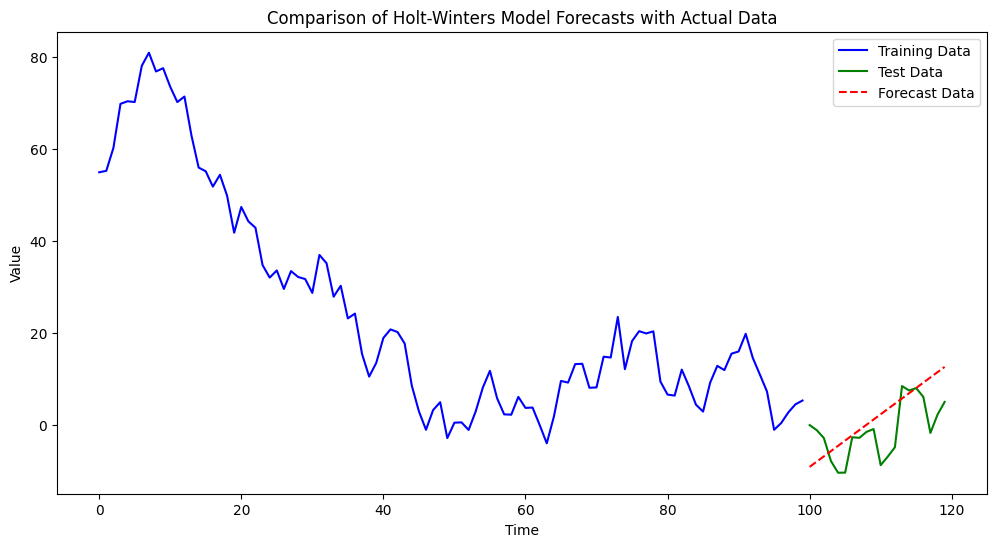

In [ ]:
import matplotlib.pyplot as plt

# Suponha que você já tenha o seguinte:
# data: os dados reais de todo o período
# train_size: o tamanho dos dados de treino
# forecast_periods: o número de períodos para previsão
# optimized_forecasts: as previsões feitas com parâmetros otimizados

# Dados para plotagem
time_train = range(train_size)  # Tempo para dados de treino
time_test = range(train_size, train_size + forecast_periods)  # Tempo para dados de teste/previsão
train_data = data[:train_size]  # Dados de treino
test_data = data[train_size:train_size + forecast_periods]  # Dados de teste

# Criando o plot
plt.figure(figsize=(12, 6))
plt.plot(time_train, train_data, label='Training Data', color='blue')
plt.plot(time_test, test_data, label='Test Data', color='green')
plt.plot(time_test, optimized_forecasts, label='Forecast Data', color='red', linestyle='--')

# Adicionando título, legendas e labels
plt.title('Comparison of Holt-Winters Model Forecasts with Actual Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Exibindo o gráfico
plt.show()
